<a href="https://colab.research.google.com/github/teoalcdor/tfg_teoalcdor/blob/main/classification_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación y Limpieza del Dataset de Clasificación

Vamos a crear un conjunto de datos de un problema de clasificación a partir del conjunto de datos de detección de vehículos civiles y militares. Para ello, seleccionamos las imágenes de este conjunto que solamente contengan un único objeto, y la clase del objeto que contienen. Crearemos también una versión del mismo en la que se emplee *data augmentation* estática al conjunto de entrenamiento.

## Librerías

Comenzamos importando las librerías necesarias:

In [ ]:
import cv2
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision import transforms

## Semilla

Fijamos la semilla por reproducibilidad. La usaremos en todos los pasos aleatorios que impliquen la ceación del conjunto de datos.

In [ ]:
SEED = 123

## Carga de los Datos

Cargarmos nuestro Google Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/



Extraemos el .zip para tener almacenados los datos localmente. De esta forma todo será más rápido.

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/Military and Civilian Vehicles Classification.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

## Creación del *Dataset*

Extraemos las anotaciones de los conjuntos de validación y test que vienen por defecto en los datos:

In [ ]:
train_labels = pd.read_csv("/content/Military and Civilian Vehicles Classification/Labels/CSV Format/train_labels.csv")
test_labels = pd.read_csv("/content/Military and Civilian Vehicles Classification/Labels/CSV Format/test_labels.csv")

train_labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000_14M0LD-e1525732547750-400x250.jpg,400,250,military tank,121,60,220,144
1,000_14M0LD-e1525732547750-400x250.jpg,400,250,military tank,198,108,371,197
2,000_1H95VB.width-800.jpg,800,532,military aircraft,30,168,622,505
3,000_1LC27X-e1570900274807-1024x640.jpg,1024,640,military tank,78,92,858,563
4,000_1LC27X-e1570900274807-1024x640.jpg,1024,640,military truck,816,288,1012,554


Vemos que traen todo lo necesario para aplicar un algoritmo de detección de objetos. Necesitamos quedarnos solo con las imágenes que tengan un único objeto y solo con dos columnas, el nombre de la imagen y el objeto. Para ello nos ayudamos de pandas:

In [ ]:
train_images = (
    train_labels.groupby(["filename"])
      .agg(
          objects=("filename", "size"),
          object_class=("class", "first")
          )
      .reset_index())
train_images = train_images[(train_images["objects"] == 1)]

train_images = train_images[["filename", "object_class"]]

train_images.head()


,filename,object_class
1,000_1H95VB.width-800.jpg,military aircraft
3,0023ae82ca0f1487c33a46.jpg,civilian aircraft
4,01-BOAC-Comet-1-G-BOAC-AI-PM-1953-0603-Marvin-...,civilian aircraft
5,01-honda-civic-si-sedan.jpg,civilian car
6,0101020114.side.jpg,civilian car


In [ ]:
test_images = (
    test_labels.groupby(["filename"])
      .agg(
          objects=("filename", "size"),
          object_class=("class", "first")
          )
      .reset_index())


test_images = test_images[(test_images["objects"] == 1)]

test_images = test_images[["filename", "object_class"]]

test_images.head()

,filename,object_class
1,000_1H95VB.width-800.jpg,military aircraft
3,01-BOAC-Comet-1-G-BOAC-AI-PM-1953-0603-Marvin-...,civilian aircraft
4,01-honda-civic-si-sedan.jpg,civilian car
5,01convoy01.jpg,military truck
6,0TREpvY3xoDJIKMK8.jpg,military tank


Observamos que hay imagenes que aparecen en los conjuntos de test y validación. Unimos ambos conjuntos eliminando duplicados y vemos los resultados:

In [ ]:
image_labels = pd.concat([train_images, test_images]).drop_duplicates().reset_index(drop=True)
image_labels.shape[0]

5297

In [ ]:
image_labels.groupby("object_class").count()

,filename
object_class,
civilian aircraft,808
civilian car,793
military aircraft,788
military helicopter,950
military tank,1224
military truck,734


El reparto parece estar balanceado.

Creamos ahora un directorio para nuestro nuevo conjunto de datos:

In [ ]:
os.makedirs("classification_dataset")
os.makedirs("classification_dataset/images")

Movemos las fotos correspondientes a nuestro al directorio:

In [ ]:
# Vamos a contabilizar cuantas imagenes encontramos y cuantas no
n_missing = 0
n_found = 0

# Recorremos las imagenes
for ix, image in enumerate(image_labels["filename"]):
  try: # Si la encontramos, la movemos
    shutil.move(
        f"/content/Military and Civilian Vehicles Classification/Images/{image}",
        f"/content/classification_dataset/images/{image}",
        copy_function=shutil.copy2
    )
    n_found += 1
  except: # Si no la encontramos, la quitamos del DataFrame
        image_labels.drop(ix, inplace=True)
        n_missing += 1
image_labels.reset_index(drop=True, inplace=True)

print(f"Found: {n_found}")
print(f"Missing: {n_missing}")

Found: 5294
Missing: 3


Tres de las 5297 que se supone que debía haber en el dataset no están, por lo que nos quedamos con 5294. Esto no supone una gran pérdida.

Asignamos etiquetas a cada clase:

In [ ]:
classes = image_labels["object_class"].unique()
label_encoder = LabelEncoder()
label_encoder.fit(classes)
image_labels["object_class"] = label_encoder.transform(image_labels["object_class"])
image_labels["object_class"].unique()

array([2, 0, 1, 5, 3, 4])

In [ ]:
label_encoder.inverse_transform(range(6))

array(['civilian aircraft', 'civilian car', 'military aircraft',
       'military helicopter', 'military tank', 'military truck'],
      dtype=object)

Hacemos la división en conjunto de entrenamiento y validación estratificando según las clases:

In [ ]:
train_labels, val_labels = train_test_split(
    image_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=image_labels["object_class"]
)

## Análisis Exploratorio de los Datos

Contabilizamos cuántos individuos hay de cada clase:

In [ ]:
class_counts_train = train_labels["object_class"].value_counts().reset_index().sort_values(by="object_class")
class_counts_train

,object_class,count
2,0,646
3,1,634
4,2,630
1,3,760
0,4,978
5,5,587


In [ ]:
class_counts_val = val_labels["object_class"].value_counts().reset_index().sort_values(by="object_class")
class_counts_val

,object_class,count
2,0,162
3,1,159
4,2,157
1,3,190
0,4,245
5,5,146


Representamos la distribución de clases en ambos subconjuntos:

<ipython-input-17-b78b877b86fa>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(ordered_classes, rotation=90)
<ipython-input-17-b78b877b86fa>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(ordered_classes, rotation=90)


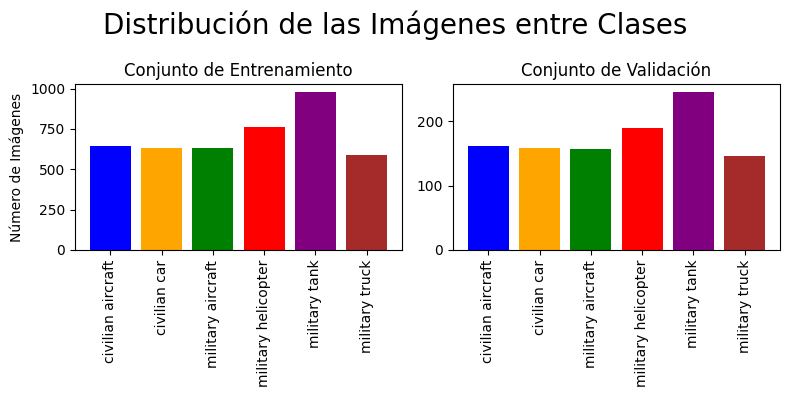

In [ ]:
# Ponemos las clases ordenadas y los colores
arranged_classes = label_encoder.inverse_transform(np.arange(6))
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Representamos la grafica de barras
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].bar(arranged_classes, class_counts_train["count"], color=color)
ticks_x = axs[0].get_xticks()
axs[0].set_xticks(ticks_x)
axs[0].set_xticklabels(arranged_classes, rotation=90)
axs[0].set_title("Conjunto de Entrenamiento")
axs[0].set_ylabel("Número de Imágenes")
axs[1].bar(arranged_classes, class_counts_val["count"], color=color)
ticks_x = axs[1].get_xticks()
axs[1].set_xticks(ticks_x)
axs[1].set_xticklabels(arranged_classes, rotation=90)
axs[1].set_title("Conjunto de Validación")
fig.suptitle("Distribución de las Imágenes entre Clases", fontsize=20)
fig.tight_layout()

Tomamos una muestra del conjunto de entrenamiento:

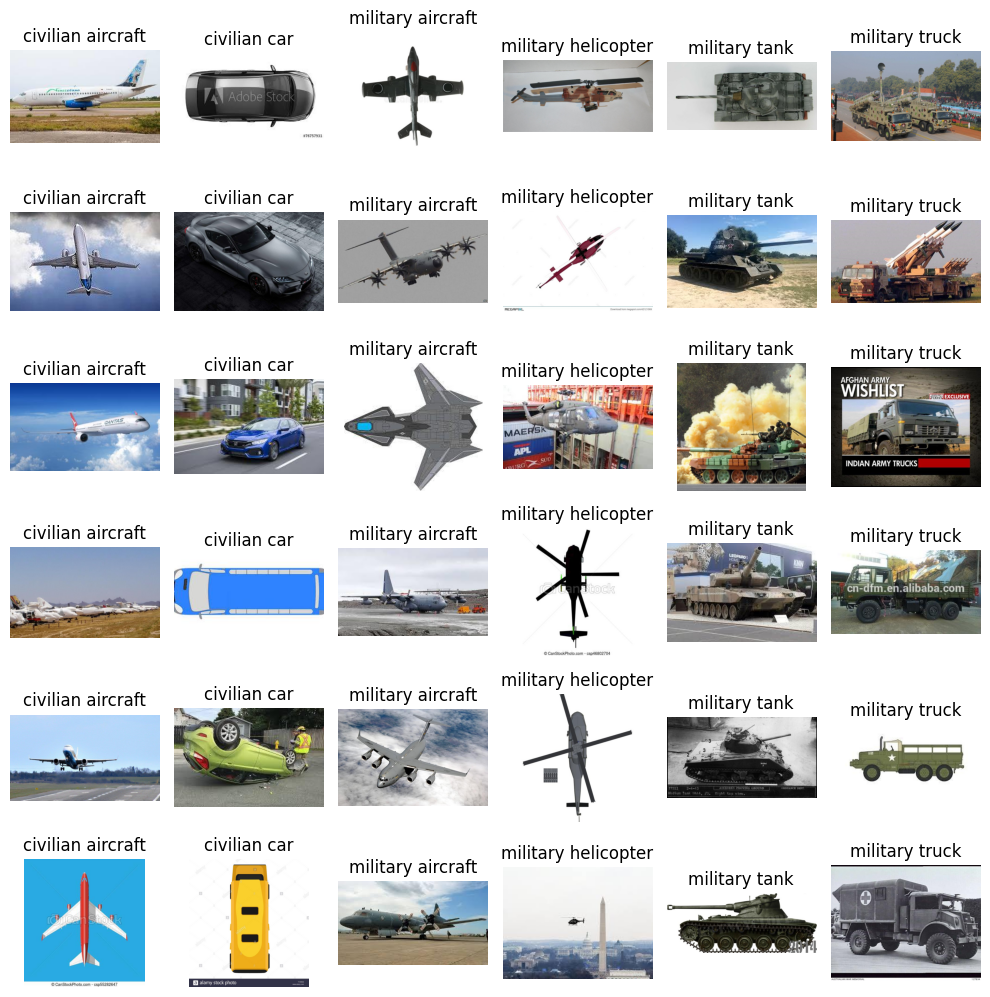

In [ ]:
# Vamos a representar 6 imagenes de cada clase
n_classes = len(arranged_classes)
n_images = 6

# Representamos las imagenes
fig, axs = plt.subplots(n_images, n_classes, figsize=(10, 10))
for j in range(n_classes):
    class_imgs = train_labels["filename"][train_labels["object_class"].values == j].values
    for i in range(n_images):
        img = cv2.imread(f"/content/classification_dataset/images/{class_imgs[i]}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        axs[i, j].set_title(arranged_classes[j])

fig.tight_layout()

Salvamos nuestro DataFrame con las etiquetas de este nuevo conjunto de datos en formato CSV en nuestro nuevo directorio:

In [ ]:
train_labels.to_csv("/content/classification_dataset/train_labels.csv", index=False)
val_labels.to_csv("/content/classification_dataset/val_labels.csv", index=False)

## Data Augmentation Estática

Definimos la transformación que haremos:

In [ ]:
# Ojo, no hace resize ni normaliza, eso se hara en el dataloader
AUG_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.GaussianBlur(kernel_size=25, sigma=(10.0, 20.0)),
        transforms.ColorJitter(
            brightness=(0.5,1.5),
            contrast=(0.8,1.2),
            saturation=(0.8,1.2),
            hue=0.25
        )
    ]),
    transforms.RandomAffine(5, translate=(0.01, 0.1)),
    transforms.RandomHorizontalFlip(p=0.85),
    transforms.RandomVerticalFlip(p=0.01),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.01, 0.1)),
])

Copiamos el *dataset* para añadirle las imágenes modificadas:

In [ ]:
shutil.copytree("/content/classification_dataset",
                "/content/classification_dataset_augmented")

'/content/classification_dataset_augmented'

Eliminamos las etiquetas de entrenamiento, crearemos las nuevas a partir del *dataset* augmentado:

In [ ]:
os.remove("/content/classification_dataset_augmented/train_labels.csv")

Realizamos las augmentations de forma reproducible:

In [ ]:
# Por reproducibilidad, inicializamos las semillas
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Inicialiamos las semillas
augmented_train_labels = train_labels.copy()
augmented_train_labels.reset_index(drop=True, inplace=True)
n_ = train_labels.shape[0]

list_destination_filenames = train_labels["filename"].values

for filename in tqdm(list_destination_filenames, total=n_):
    # Leemos la imagen en RGB
    img = cv2.imread(f"datos/classification_dataset/images/{filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Realizamos la augmentation y la pasamos a BGR para guardarla
    img_aug = AUG_TRANSFORM(img)
    img_aug = cv2.cvtColor(
      (img_aug.permute(1,2,0).numpy() * 255).astype(np.uint8),
      cv2.COLOR_RGB2BGR
    )

    # Guardamos la imagen augmentada
    name = filename[:-4]
    extension = filename[-4:]
    destination_name = name + "_augmented"

    while destination_name + extension in list_destination_filenames:
        destination_name += "_augmented"

    _ = cv2.imwrite(f"datos/classification_dataset_augmented/images/{destination_name}.jpg",
                        img_aug)

    # Actualizamos el dataframe con la imagen augmentada
    augmented_train_labels.loc[len(augmented_train_labels)] = [
        f"{destination_name}.jpg",
        train_labels.loc[train_labels["filename"] == f"{name}.jpg"]["object_class"].values[0]
    ]

augmented_train_labels.to_csv("datos/classification_dataset_augmented/train_labels.csv", index=False)

## Subida del Conjunto de Datos a Google Drive


Comprimimos el conjunto de datos sin *data augmentation*:

In [ ]:
shutil.make_archive(
    '/content/classification_dataset',
    'zip',
    '/content',
    'classification_dataset'
)

'/content/classification_dataset.zip'

Subimos el conjunto de datos en formato ZIP a Google Drive para poder utilizarlo en otros ficheros:

In [ ]:
shutil.copy(
    "/content/classification_dataset.zip",
    "/content/drive/MyDrive/tfg/datasets/classification_dataset.zip"
)

'/content/drive/MyDrive/tfg/datasets_aux/classification_dataset.zip'

Comprimimos el conjunto de datos con *data augmentation*:

In [ ]:
shutil.make_archive(
    '/content/classification_dataset_augmented',
    'zip',
    '/content',
    'classification_dataset_augmented'
)

'/content/classification_dataset_augmented_aux.zip'

Copiamos el *dataset* aumentado a Drive:

In [ ]:
shutil.copy(
    "/content/classification_dataset_augmented.zip",
    "/content/drive/MyDrive/tfg/datasets/classification_dataset_augmented.zip"
)

'/content/drive/MyDrive/tfg/datasets_aux/classification_dataset_augmented_aux.zip'